# Group 7
# ADS 504 Summer 2024

In [1]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the data

file_path = "/content/drive/MyDrive/ADS504/project/nvda_2018.csv"

#file_path = "/workspaces/ADS-504-02-Group-7-Machine-Learning-and-Deep-Learning-for-Data-Science/nvda_2018.csv"
data = pd.read_csv(file_path)

## TEST. Ensure data shows for given file_path. Comment out ones not unique to you.

In [4]:
data.tail()

,time,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,...,ImpulseMACDCDSignal,RSI,Regular Bullish,Regular Bullish Label,Hidden Bullish,Hidden Bullish Label,Regular Bearish,Regular Bearish Label,Hidden Bearish,Hidden Bearish Label
11746,1721662200,120.79,121.92,120.36,121.77,120.79,121.92,120.36,121.77,120.221167,...,-0.814735,52.050358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11747,1721665800,121.77,122.95,121.54,122.80,121.77,122.95,121.54,122.80,120.223936,...,-0.376382,54.743276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11748,1721669400,122.81,124.07,122.60,123.52,122.81,124.07,122.60,123.52,120.230377,...,-0.119291,56.579041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11749,1721673000,123.51,123.75,122.62,122.84,123.51,123.75,122.62,122.84,120.234539,...,0.000000,54.337262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11750,1721676600,122.87,123.74,122.71,123.74,122.87,123.74,122.71,123.74,120.238511,...,0.000000,56.778209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature engineering.
### Convert original UNIX 'time' to datetime object

In [5]:
#Convert UNIX time to datetime object
data['time'] = pd.to_datetime(data['time'], unit='s')

### Add feature. Day of the week.

In [6]:
#Feature Engineering. Day of the week.
data['day_of_week'] = data['time'].dt.day_name()
data.insert(1, 'day_of_week', data.pop('day_of_week'))

### Convert from UTC time to America/New_York time (where NYSE trades)

In [7]:
#Convert to New York time (Where NYSE trades)
data['time'] = data['time'].dt.tz_localize('GMT')
data['time'] = data['time'].dt.tz_convert('America/New_York')

### Add feature. Morning / Afternoon categories.

In [8]:
#Feature Engineering. Morning/Afternoon
data['session'] = data['time'].dt.hour.apply(lambda x:
                                             'Morning' if x<12 else 'Afternoon')
data.insert(2, 'session', data.pop('session'))

### Add feature. Target = Percent price change (*100 for percent)

In [9]:
# Feature Engineering
data["target"] = data["close"] - data["open"]
data["target"] = (data["target"] / data["open"])*100


### Add feature. Target_t+1 to be used as "forecasted" value. Use as model evaluation metric using RMSE. Penalize larger errors greater.

In [10]:
data["target_t+1"] = data["target"].shift(-1)


### Checkpoint. Post-Feature Engineering.

In [11]:
data.tail()

,time,day_of_week,session,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),...,Regular Bullish,Regular Bullish Label,Hidden Bullish,Hidden Bullish Label,Regular Bearish,Regular Bearish Label,Hidden Bearish,Hidden Bearish Label,target,target_t+1
11746,2024-07-22 11:30:00-04:00,Monday,Morning,120.79,121.92,120.36,121.77,120.79,121.92,120.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.811325,0.845857
11747,2024-07-22 12:30:00-04:00,Monday,Afternoon,121.77,122.95,121.54,122.80,121.77,122.95,121.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.845857,0.578129
11748,2024-07-22 13:30:00-04:00,Monday,Afternoon,122.81,124.07,122.60,123.52,122.81,124.07,122.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.578129,-0.542466
11749,2024-07-22 14:30:00-04:00,Monday,Afternoon,123.51,123.75,122.62,122.84,123.51,123.75,122.62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.542466,0.708065
11750,2024-07-22 15:30:00-04:00,Monday,Afternoon,122.87,123.74,122.71,123.74,122.87,123.74,122.71,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.708065,NaN


## EDA

### Explore cardinality and remove null or columns with no variation (1 or 0 cardinality)

In [12]:
cardinality = data.nunique()

# Remove columns with 1 or 0 cardinality
col_keep = cardinality[cardinality > 1].index
data = data[col_keep]
data.nunique()

,0
time,11751
day_of_week,5
session,2
open,10722
high,10554
low,10592
close,10605
PlotCandle (Open),10722
PlotCandle (High,10554
PlotCandle (Low),10592


Create dataframe subsets of regular bullish, regular bearish, and hourly price movements of greater than 1 percent to attempt to find confounders.

In [13]:
reg_bull = data.dropna(subset=['Regular Bullish'])
reg_bear = data.dropna(subset=['Regular Bearish'])
gt_p1 = data[data['target']>1]
gt_n1 = data[data['target']<1]

Text(0, 0.5, 'Stock Price Change')

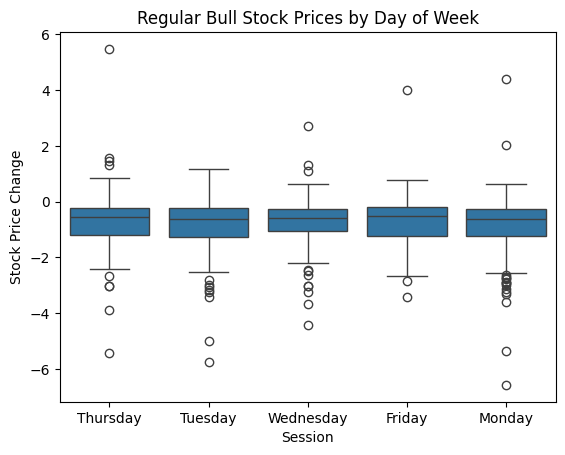

In [14]:
sns.boxplot(data = reg_bull, x = 'day_of_week', y = 'target')
plt.title('Regular Bull Stock Prices by Day of Week')
plt.xlabel('Session')
plt.ylabel('Stock Price Change')

Text(0, 0.5, 'Stock Price Change')

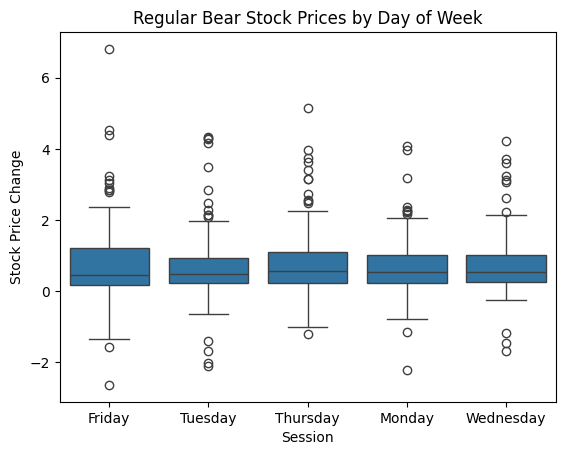

In [15]:
sns.boxplot(data = reg_bear, x = 'day_of_week', y = 'target')
plt.title('Regular Bear Stock Prices by Day of Week')
plt.xlabel('Session')
plt.ylabel('Stock Price Change')

## EDA. Visualization.

### Price Change: Session

Text(0, 0.5, 'Stock Price Change')

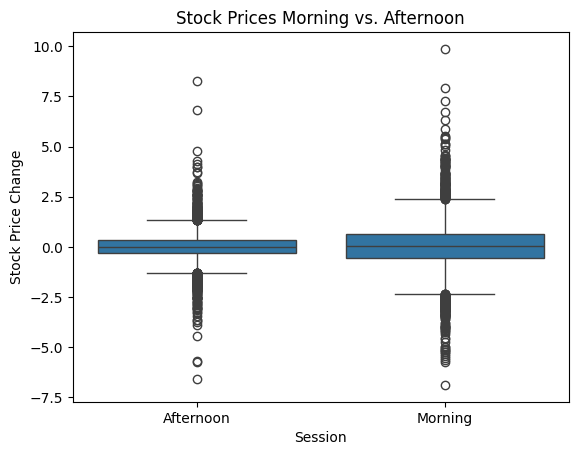

In [16]:
sns.boxplot(data = data, x = 'session', y = 'target')
plt.title('Stock Prices Morning vs. Afternoon')
plt.xlabel('Session')
plt.ylabel('Stock Price Change')

Many outliers present in price. Should handle with appropriate method (clipping) to minimize affect on standard deviation and mean.

### Price Change: Day of the Week

Text(0, 0.5, 'Stock Price Change')

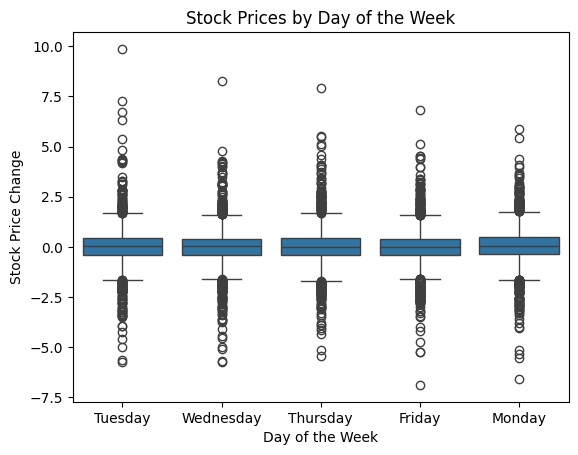

In [17]:
sns.boxplot(data = data, x = 'day_of_week', y = 'target')
plt.title('Stock Prices by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Stock Price Change')

### Regular Bullish/Bearish Value Distribution

Text(0.5, 1.0, 'Regular Bullish vs Regular Bearish')

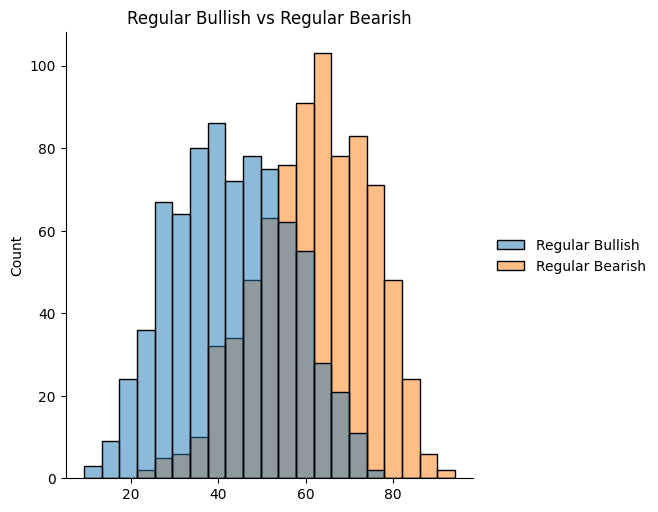

In [18]:
df = pd.DataFrame(data)
sns.displot(df[['Regular Bullish', 'Regular Bearish']])
plt.title('Regular Bullish vs Regular Bearish')

## Data Cleaning. Handle outliers with clipping.

In [19]:
num_cols = data.select_dtypes(include=[np.number])

Q1 = num_cols.quantile(.25)
Q3 = num_cols.quantile(.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

num_cols_clipped = num_cols.clip(lower=lower_bound, upper=upper_bound, axis=1)
data = num_cols_clipped.join(data.drop(columns=num_cols.columns))

## Checkpoint. Post-Data Cleaning: Clipped.



In [20]:
data.head()

,open,high,low,close,PlotCandle (Open),PlotCandle (High,PlotCandle (Low),PlotCandle (Close),VWAP,Upper Band #1,...,Regular Bullish Label,Hidden Bullish,Regular Bearish,Regular Bearish Label,Hidden Bearish,target,target_t+1,time,day_of_week,session
0,5.2830,5.30175,5.28300,5.30025,5.2830,5.30175,5.28300,5.30025,4.462440,4.817839,...,NaN,NaN,NaN,NaN,NaN,0.326519,-1.128423,2017-11-07 15:30:00-05:00,Tuesday,Afternoon
1,5.2950,5.29825,5.21275,5.23525,5.2950,5.29825,5.21275,5.23525,4.464509,4.821719,...,NaN,NaN,NaN,NaN,NaN,-1.128423,0.023875,2017-11-08 09:30:00-05:00,Wednesday,Morning
2,5.2355,5.26125,5.23000,5.23675,5.2355,5.26125,5.23000,5.23675,4.465430,4.823430,...,NaN,NaN,NaN,NaN,NaN,0.023875,-0.338999,2017-11-08 10:30:00-05:00,Wednesday,Morning
3,5.2360,5.24300,5.18225,5.21825,5.2360,5.24300,5.18225,5.21825,4.466655,4.825640,...,NaN,NaN,NaN,NaN,NaN,-0.338999,-0.268431,2017-11-08 11:30:00-05:00,Wednesday,Morning
4,5.2155,5.22200,5.18750,5.20150,5.2155,5.22200,5.18750,5.20150,4.467462,4.827079,...,NaN,NaN,NaN,NaN,NaN,-0.268431,0.182701,2017-11-08 12:30:00-05:00,Wednesday,Afternoon


## Plot boxplots of outlier-handled data

### Updated. Day of the Week.

Text(0, 0.5, 'Stock Price Change')

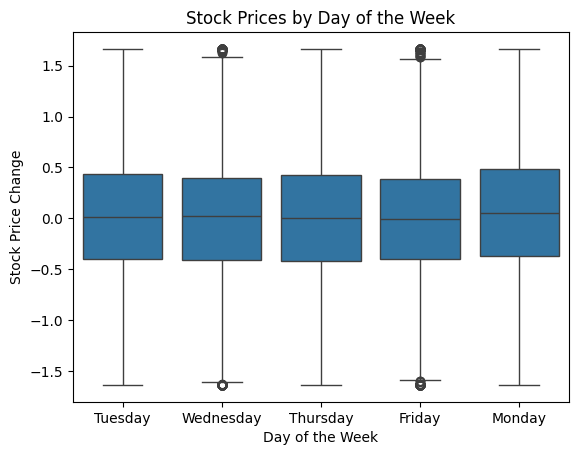

In [21]:
sns.boxplot(data = data, x = 'day_of_week', y = 'target')
plt.title('Stock Prices by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Stock Price Change')

### Updated. Session.

Text(0, 0.5, 'Stock Price Change')

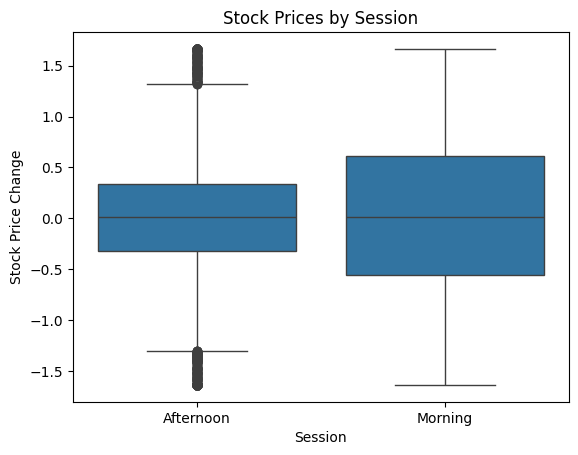

In [22]:
sns.boxplot(data = data, x = 'session', y = 'target')
plt.title('Stock Prices by Session')
plt.xlabel('Session')
plt.ylabel('Stock Price Change')

In [23]:
data.groupby('session').describe()['target']

,count,mean,std,min,25%,50%,75%,max
session,,,,,,,,
Afternoon,6699.0,0.005679,0.599352,-1.637091,-0.318547,0.013182,0.336069,1.665307
Morning,5052.0,0.016143,0.902265,-1.637091,-0.561553,0.018179,0.617106,1.665307


Morning trading sessions exhibit higher volatility in the form of standard deviation (.90) versus the afternoon (.60). Central tendency metrics mean and median suggest the most bullish action between the two occurs in the morning amidst this increased volatility.

In [24]:
data.groupby('day_of_week').describe()['target']

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,2355.0,-0.012123,0.744993,-1.637091,-0.404087,-0.009415,0.389759,1.665307
Monday,2185.0,0.049599,0.750752,-1.637091,-0.365559,0.047916,0.483657,1.665307
Thursday,2384.0,0.002396,0.752685,-1.637091,-0.421622,0.007749,0.424181,1.665307
Tuesday,2418.0,0.012068,0.736183,-1.637091,-0.403171,0.017794,0.432958,1.665307
Wednesday,2409.0,0.002028,0.739261,-1.637091,-0.405443,0.018879,0.401473,1.665307


Central tendencies suggest that Fridays are sell-off days as depicted by mean and median being negative values / negative hourly behavior. Mondays show the most positive dispersion on central tendency on the same metrics.

In [25]:
gt_p1.groupby('day_of_week').describe()['target']

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,213.0,1.736715,0.848202,1.001647,1.202395,1.453155,1.942769,6.806700
Monday,224.0,1.736699,0.776630,1.000822,1.168753,1.509145,2.123614,5.893402
Thursday,222.0,1.832957,0.971887,1.000052,1.204867,1.473572,2.162348,7.906803
Tuesday,211.0,1.822286,1.117187,1.008438,1.214712,1.488834,1.932252,9.866607
Wednesday,215.0,1.735343,0.876777,1.000656,1.189612,1.463557,1.972845,8.284559


Screening for hours of greater than 1% or more on price movement, Mondays hold a plurality. Mondays also show the lowest standard deviation and volatility.

In [26]:
gt_n1.groupby('day_of_week').describe()['target']

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,2142.0,-0.189084,0.738558,-6.882470,-0.466638,-0.079225,0.262454,0.998390
Monday,1961.0,-0.145408,0.754830,-6.572502,-0.413200,-0.030808,0.313845,0.997249
Thursday,2162.0,-0.176555,0.730328,-5.427657,-0.468160,-0.059128,0.284783,0.998956
Tuesday,2207.0,-0.158294,0.734135,-5.760611,-0.472473,-0.042697,0.307877,0.997370
Wednesday,2194.0,-0.171763,0.738937,-5.751588,-0.462342,-0.042221,0.272885,0.997340


Screening for hours of greater than 1% or more on negative price movement, Tuesdays hold a plurality. These movements also occur roughly 10 times more often than their positive counterpart of greater than 1%. Volatility across these hours is generally the same with Thursday being the lowest.

Text(0, 0.5, 'Stock Price Change')

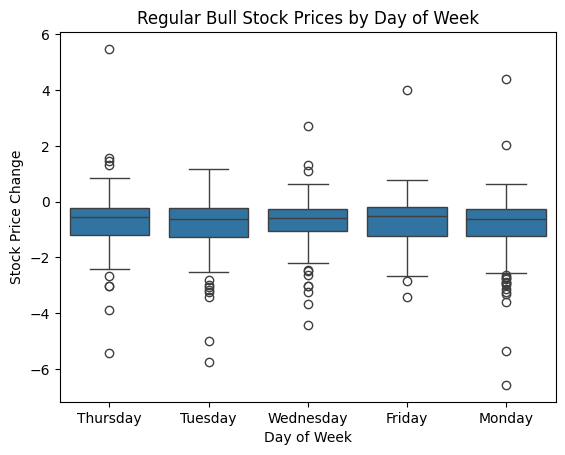

In [27]:
sns.boxplot(data = reg_bull, x = 'day_of_week', y = 'target')
plt.title('Regular Bull Stock Prices by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Stock Price Change')

In [28]:
reg_bull.groupby('day_of_week').describe()['target']

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,158.0,-0.736964,0.829711,-3.429817,-1.235991,-0.502420,-0.196189,3.998511
Monday,140.0,-0.908058,1.174021,-6.572502,-1.220421,-0.622988,-0.273476,4.389146
Thursday,152.0,-0.735749,1.016988,-5.427657,-1.187174,-0.557263,-0.237785,5.481799
Tuesday,159.0,-0.851707,0.954012,-5.760611,-1.256076,-0.608867,-0.240562,1.186403
Wednesday,164.0,-0.762962,0.847738,-4.434762,-1.043438,-0.599009,-0.276872,2.727709


On days labeled as regular bullish, central tendencies show negative mean and median. This may be interpreted as a "bottom" being found on downward price movement that may be characterized as an inflection point where future price changes are likely to turn positive. Mondays are the the most most volatile of these days, signaling beginning-of-the-week news may have had an influence on price. Wednesdays demonstrate a plurality of bullish signals.

Text(0, 0.5, 'Stock Price Change')

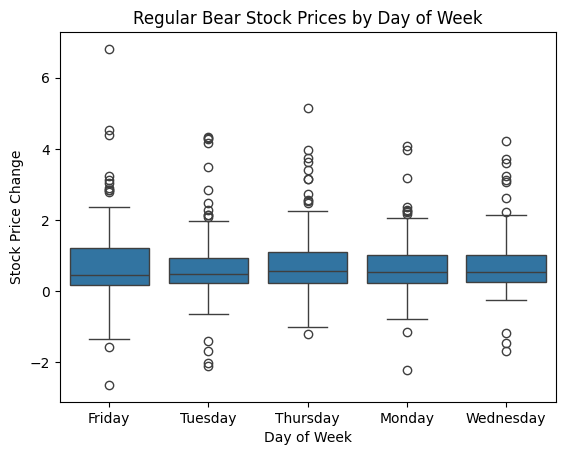

In [29]:
sns.boxplot(data = reg_bear, x = 'day_of_week', y = 'target')
plt.title('Regular Bear Stock Prices by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Stock Price Change')

In [30]:
reg_bear.groupby('day_of_week').describe()['target']

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,148.0,0.757835,1.099519,-2.633686,0.173167,0.460361,1.216124,6.806700
Monday,153.0,0.703122,0.768455,-2.206649,0.240667,0.550211,1.002783,4.079568
Thursday,172.0,0.756876,0.904961,-1.210700,0.216661,0.564020,1.092653,5.151490
Tuesday,151.0,0.692452,0.937968,-2.102083,0.224821,0.493673,0.933295,4.345561
Wednesday,158.0,0.749976,0.825262,-1.692091,0.245117,0.545848,1.022516,4.219840


On days labeled as regular bearish, central tendencies show positive mean and median. This may be interpreted as a "top" being found on upward price movement that may be characterized as an inflection point where future price changes are likely to turn negative. Fridays are the the most volatile of these days, signaling end-of-the-week selling may have had an influence on price to get ahead of unknown events that may occur over the weekend. Thursdays demonstrate a plurality of bullish signals.

## EDA findings.
### Mornings show 50% more volatility than afternoons. When there is a positive price movement it is most likely to occur on a Monday. When there's a negative price movement it is most likely to occur on a Friday. The most severe drops occur on Tuesdays and Wednesdays, though these occurences are less frequent, suggesting they either preempt or are in response to Wednesday fiscal reporting.

### From a risk-return perspective, generally the safest times to buy may be on Fridays and the best time to sell may be on Monday mornings. However, if instead of safety/consistency an investor wants to to maximize returns, then it is most probabable to sell on Monday still, but then buy on Tuesday or Wednesdays.

## Data Cleaning. Handle missing values.

In [31]:
data.isnull().sum()

,0
open,0
high,0
low,0
close,0
PlotCandle (Open),0
PlotCandle (High,0
PlotCandle (Low),0
PlotCandle (Close),0
VWAP,0
Upper Band #1,0


Missing values in these columns are acceptable since they are flags. Null values mean that there are no bullish or bearish labels to be applied to the corresponding record. For any modeling purposes that are not able to handle missing values, these columns should be dropped. For all other models, these should be kept due to their inherent labeling as a bullish or bearish signal.

In [32]:
# Correct column names
correct_column_names = [
    "time",
    "day_of_week",
    "session",
    "open",
    "high",
    "low",
    "close",
    "PlotCandle (Open)",
    "PlotCandle (High)",
    "PlotCandle (Low)",
    "PlotCandle (Close)",
    "VWAP",
    "Upper Band #1",
    "Lower Band #1",
    "Upper Band #2",
    "Lower Band #2",
    "Upper Band #3",
    "Lower Band #3",
    "MidLine",
    "ImpulseMACD",
    "ImpulseHisto",
    "ImpulseMACDSignal",
    "RSI",
    "Regular Bullish Label",
    "Regular Bullish",
    "Hidden Bullish Label",
    "Hidden Bullish",
    "Regular Bearish Label",
    "Regular Bearish",
    "Hidden Bearish Label",
    "Hidden Bearish",
]

In [33]:
# Lag Features
for lag in range(1, 4):
    data[f"close_lag_{lag}"] = data["close"].shift(lag)

# Rolling Statistics
data["close_rolling_mean_5"] = data["close"].rolling(window=5).mean()
data["close_rolling_std_5"] = data["close"].rolling(window=5).std()

In [34]:
data.columns

Index(['open', 'high', 'low', 'close', 'PlotCandle (Open)', 'PlotCandle (High',
       'PlotCandle (Low)', 'PlotCandle (Close)', 'VWAP', 'Upper Band #1',
       'Lower Band #1', 'Upper Band #2', 'Lower Band #2', 'Upper Band #3',
       'Lower Band #3', 'ImpulseMACD', 'ImpulseHisto', 'ImpulseMACDCDSignal',
       'RSI', 'Regular Bullish', 'Regular Bullish Label', 'Hidden Bullish',
       'Regular Bearish', 'Regular Bearish Label', 'Hidden Bearish', 'target',
       'target_t+1', 'time', 'day_of_week', 'session', 'close_lag_1',
       'close_lag_2', 'close_lag_3', 'close_rolling_mean_5',
       'close_rolling_std_5'],
      dtype='object')

In [35]:
# Drop unused columns
columns_to_drop = [
    "Regular Bullish",
    "Regular Bullish Label",
    "Hidden Bullish",
    "Regular Bearish",
    "Regular Bearish Label",
    "Hidden Bearish",
]
data.drop(columns=columns_to_drop, inplace=True)

# Convert categorical features to numerical
data = pd.get_dummies(
    data, columns=["day_of_week", "session"], drop_first=True
)

# Create the target variable: close - open
data["target"] = data["close"] - data["open"]
data["target_t+1"] = data["target"].shift(-1)

# Handle NaN introduced by the shift
data.dropna(subset=["target_t+1"], inplace=True)

# Extract features and target variable
X = data.drop(columns=["time", "close", "target", "target_t+1"])
y = data["target_t+1"]

In [36]:
from sklearn.impute import SimpleImputer

# Ensure alignment of X and y
X = X.iloc[:-1]
y = y.iloc[:-1]

# Impute missing values
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Initialize models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
}

random_search_xgb = RandomizedSearchCV(
    xgb_model, param_grid_xgb, n_iter=10, cv=3, scoring="r2", n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_train_scaled, y_train)
best_xgb_model = random_search_xgb.best_estimator_

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten, GRU, Input, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

# Assuming X_train_scaled, X_test_scaled, y_train, y_test, and random_search_xgb are already defined

# Initialize models
lr_model = LinearRegression()
best_rf_model = RandomForestRegressor(random_state=42)
best_xgb_model = xgb.XGBRegressor(**random_search_xgb.best_params_)

# Train models
lr_model.fit(X_train_scaled, y_train)
best_rf_model.fit(X_train_scaled, y_train)
best_xgb_model.fit(X_train_scaled, y_train)

# Evaluate models
lr_predictions = lr_model.predict(X_test_scaled)
rf_predictions = best_rf_model.predict(X_test_scaled)
xgb_predictions = best_xgb_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
xgb_mse = mean_squared_error(y_test, xgb_predictions)
xgb_r2 = r2_score(y_test, xgb_predictions)

# FFNN Model
def create_ffnn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train the FFNN model
ffnn_model = create_ffnn_model()
ffnn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the FFNN model
ffnn_predictions = ffnn_model.predict(X_test_scaled)
ffnn_mse = mean_squared_error(y_test, ffnn_predictions)
ffnn_r2 = r2_score(y_test, ffnn_predictions)

# LSTM Model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Reshape input to be [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Create and train the LSTM model
lstm_model = create_lstm_model()
lstm_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the LSTM model
lstm_predictions = lstm_model.predict(X_test_reshaped)
lstm_mse = mean_squared_error(y_test, lstm_predictions)
lstm_r2 = r2_score(y_test, lstm_predictions)

# CNN Model
def create_cnn_model():
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], 1)))
    model.add(Conv1D(64, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Reshape input to be [samples, features, channels]
X_train_cnn_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Create and train the CNN model
cnn_model = create_cnn_model()
cnn_model.fit(X_train_cnn_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the CNN model
cnn_predictions = cnn_model.predict(X_test_cnn_reshaped)
cnn_mse = mean_squared_error(y_test, cnn_predictions)
cnn_r2 = r2_score(y_test, cnn_predictions)

# GRU Model
def create_gru_model():
    model = Sequential()
    model.add(Input(shape=(1, X_train_scaled.shape[1])))
    model.add(GRU(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create and train the GRU model
gru_model = create_gru_model()
gru_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the GRU model
gru_predictions = gru_model.predict(X_test_reshaped)
gru_mse = mean_squared_error(y_test, gru_predictions)
gru_r2 = r2_score(y_test, gru_predictions)

# Transformer Model
def create_transformer_model():
    inputs = Input(shape=(1, X_train_scaled.shape[1]))
    attention = MultiHeadAttention(num_heads=2, key_dim=2)(inputs, inputs)
    attention = LayerNormalization(epsilon=1e-6)(attention)
    attention = Flatten()(attention)
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# Create and train the Transformer model
transformer_model = create_transformer_model()
transformer_model.fit(X_train_reshaped, y_train, epochs=100, batch_size=32, verbose=0)

# Evaluate the Transformer model
transformer_predictions = transformer_model.predict(X_test_reshaped)
transformer_predictions = transformer_predictions.reshape(-1, 1)  # Reshape to 2D array
transformer_mse = mean_squared_error(y_test, transformer_predictions)
transformer_r2 = r2_score(y_test, transformer_predictions)

print(f"Linear Regression MSE: {lr_mse}, R2: {lr_r2}")
print(f"Random Forest MSE: {rf_mse}, R2: {rf_r2}")
print(f"XGBoost MSE: {xgb_mse}, R2: {xgb_r2}")
print(f"Best XGBoost Parameters: {random_search_xgb.best_params_}")
print(f"FFNN MSE: {ffnn_mse}, R2: {ffnn_r2}")
print(f"LSTM MSE: {lstm_mse}, R2: {lstm_r2}")
print(f"CNN MSE: {cnn_mse}, R2: {cnn_r2}")
print(f"GRU MSE: {gru_mse}, R2: {gru_r2}")
print(f"Transformer MSE: {transformer_mse}, R2: {transformer_r2}")

# Cross-Validation Scores
cv_scores_xgb = cross_val_score(
    best_xgb_model, X_train_scaled, y_train, cv=5, scoring="r2", n_jobs=-1
)
print(f"XGBoost 5-fold CV R2: {np.mean(cv_scores_xgb)}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


67/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Linear Regression MSE: 0.03266695492983303, R2: -0.024921559034823515
Random Forest MSE: 0.0344291357316553, R2: -0.08020975772320216
XGBoost MSE: 0.03201285435032616, R2: -0.004399236487351743
Best XGBoost Parameters: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.01}
FFNN MSE: 0.04580858449786275, R2: -0.4372385164633379
LSTM MSE: 0.03874958390786459, R2: -0.21576327013355612
CNN MSE: 0.03226533315655336, R2: -0.012320726943302107
GRU MSE: 0.036699004521941754, R2: -0.1514266025237645
Transformer MSE: 0.03217525761195993, R2: -0.00949461818006081


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


XGBoost 5-fold CV R2: -0.0020804249196019866


In [39]:
import pandas as pd

# Define model names and their respective MSE and R-squared values
models = ["Linear Regression", "Random Forest", "XGBoost", "FFNN", "LSTM", "CNN", "GRU", "Transformer"]
mse_values = [lr_mse, rf_mse, xgb_mse, ffnn_mse, lstm_mse, cnn_mse, gru_mse, transformer_mse]
r2_values = [lr_r2, rf_r2, xgb_r2, ffnn_r2, lstm_r2, cnn_r2, gru_r2, transformer_r2]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": models,
    "MSE": mse_values,
    "R-squared": r2_values
})

# Print the results table
print(results_df)


               Model       MSE  R-squared
0  Linear Regression  0.032667  -0.024922
1      Random Forest  0.034429  -0.080210
2            XGBoost  0.032013  -0.004399
3               FFNN  0.045809  -0.437239
4               LSTM  0.038750  -0.215763
5                CNN  0.032265  -0.012321
6                GRU  0.036699  -0.151427
7        Transformer  0.032175  -0.009495


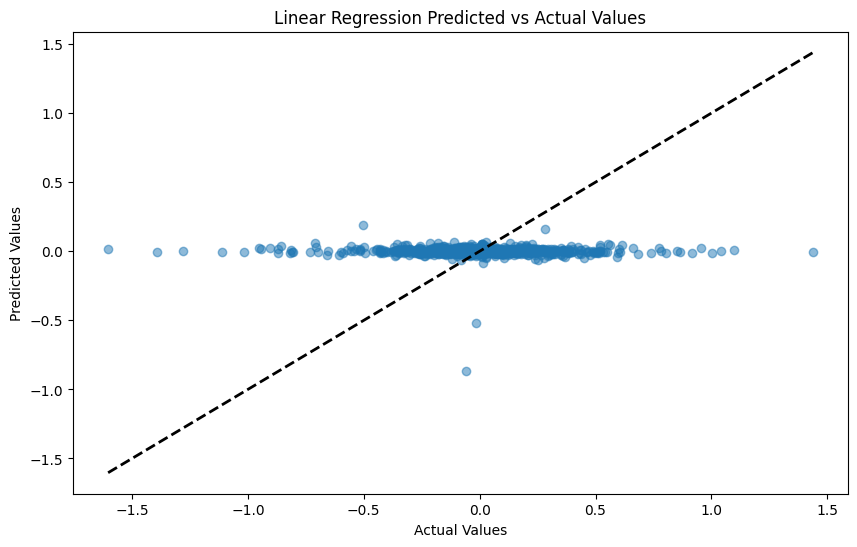

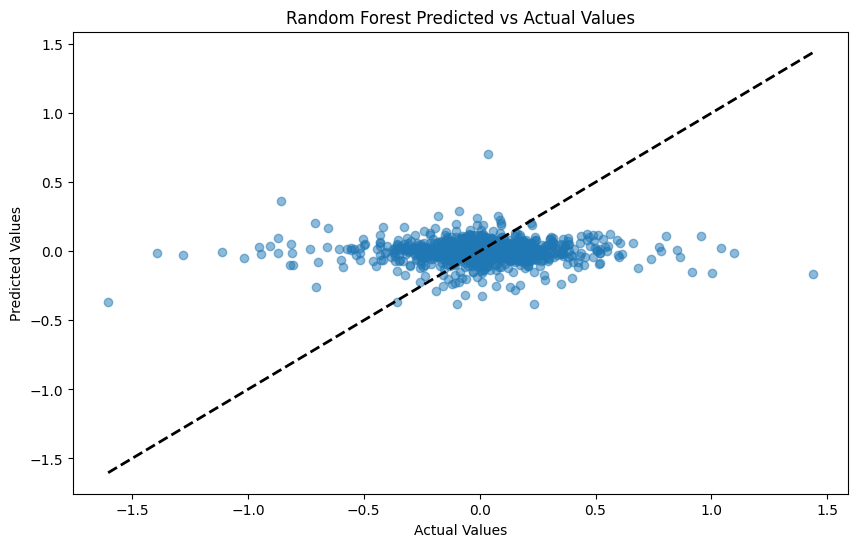

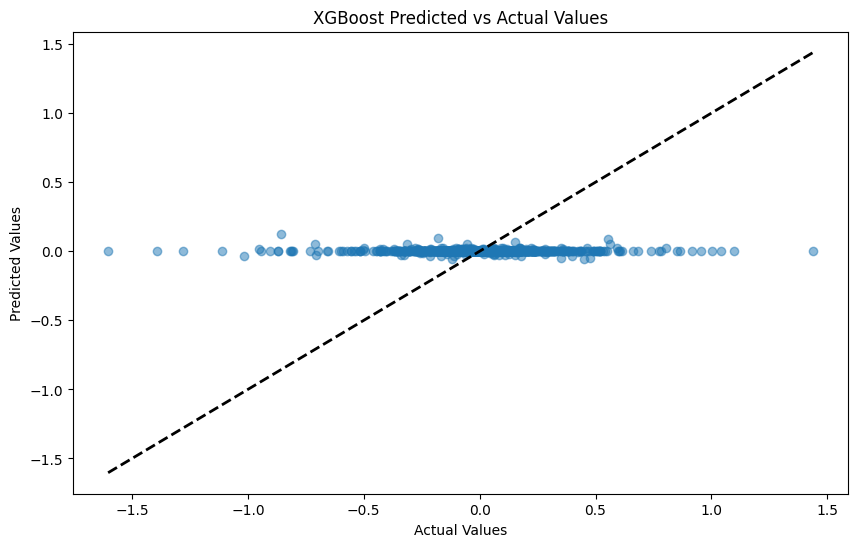

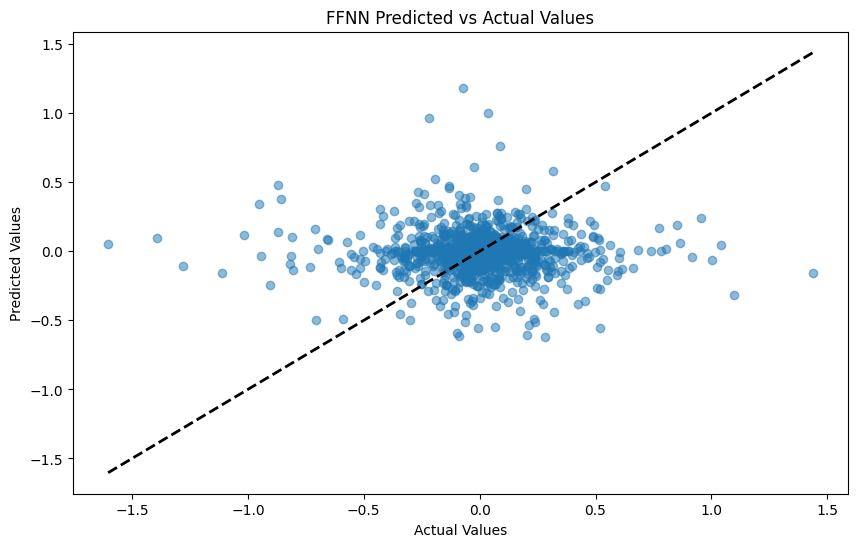

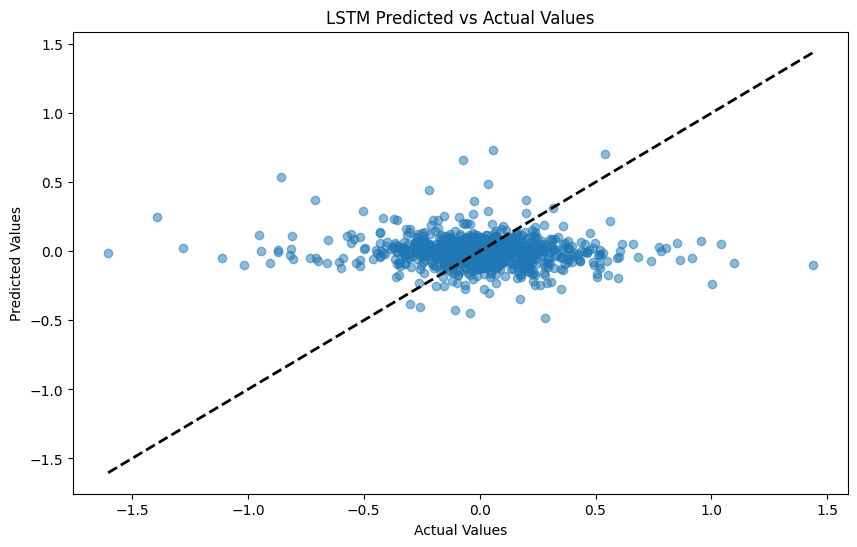

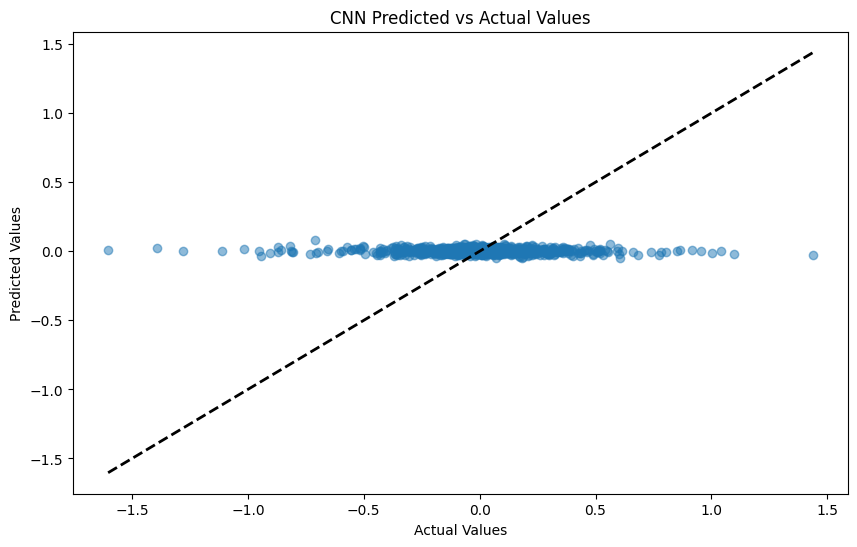

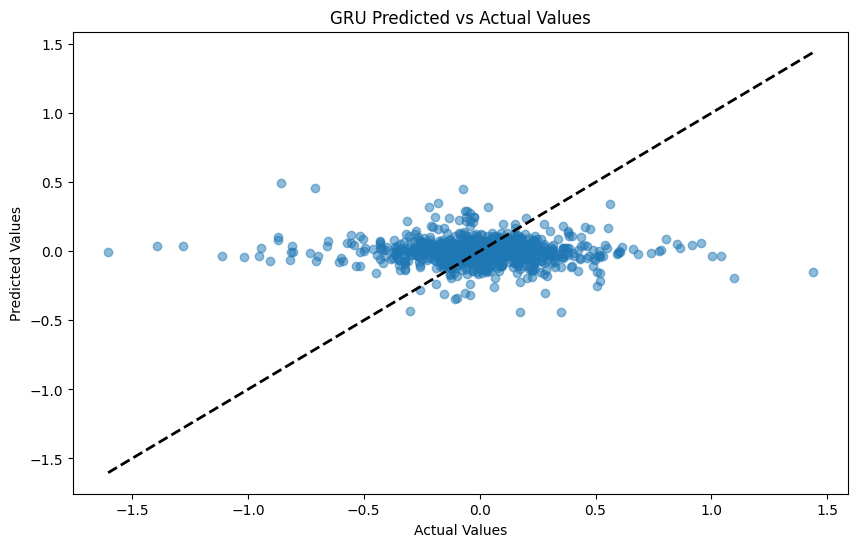

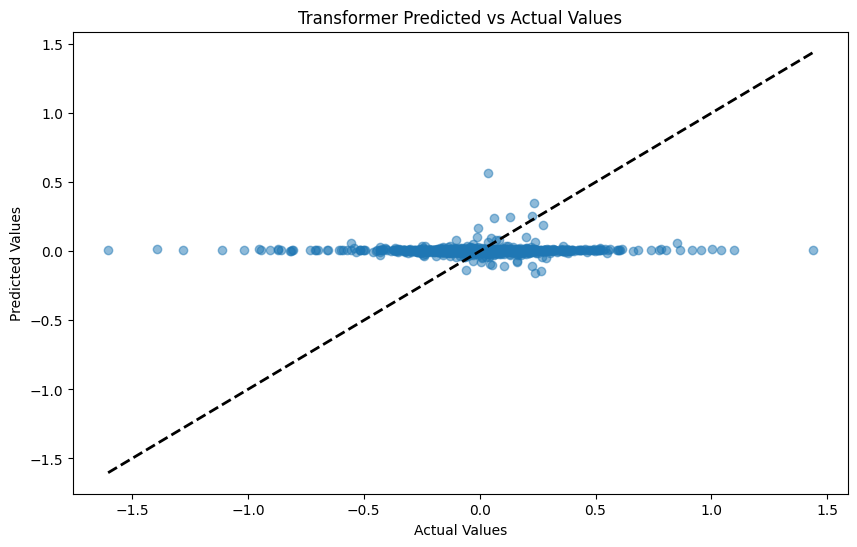

In [40]:
# Scatter Plots of predicted vs. actual values

import matplotlib.pyplot as plt

# Function to plot predicted vs actual values
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Predicted vs Actual Values')
    plt.show()

# Plot predictions for each model
plot_predictions(y_test, lr_predictions, 'Linear Regression')
plot_predictions(y_test, rf_predictions, 'Random Forest')
plot_predictions(y_test, xgb_predictions, 'XGBoost')
plot_predictions(y_test, ffnn_predictions, 'FFNN')
plot_predictions(y_test, lstm_predictions, 'LSTM')
plot_predictions(y_test, cnn_predictions, 'CNN')
plot_predictions(y_test, gru_predictions, 'GRU')
plot_predictions(y_test, transformer_predictions, 'Transformer')


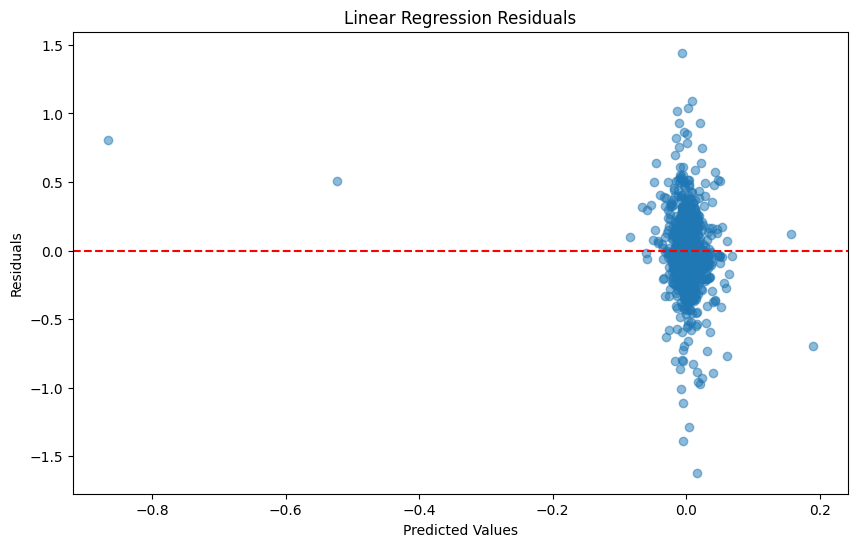

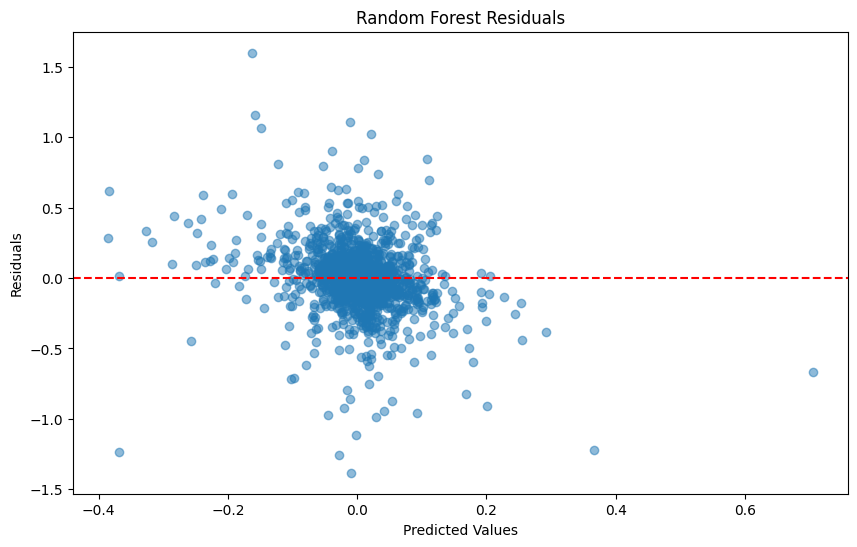

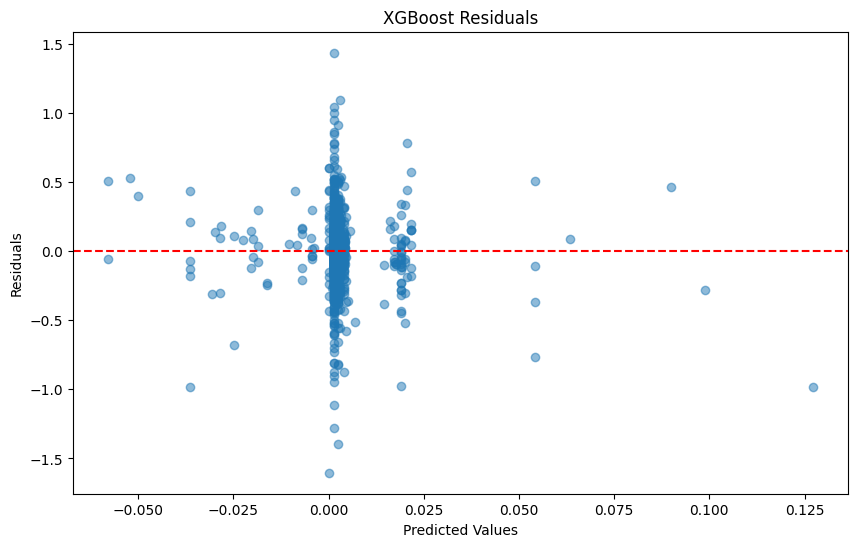

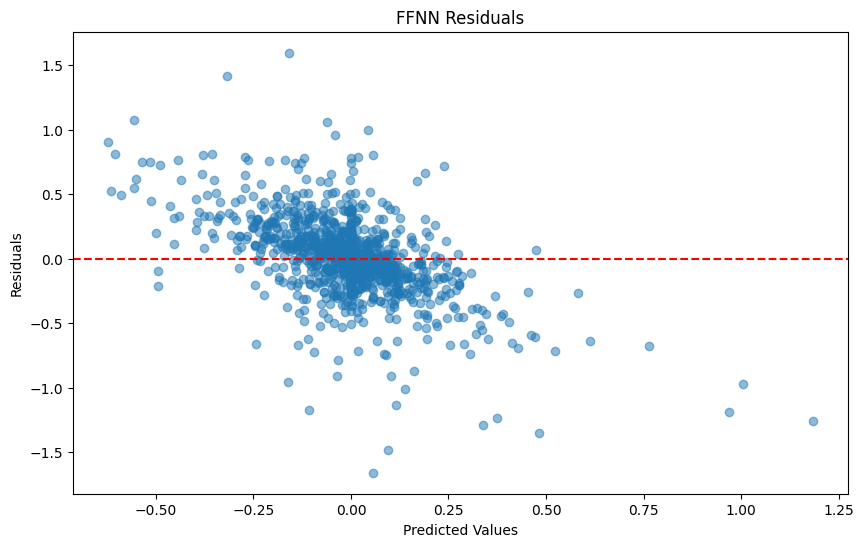

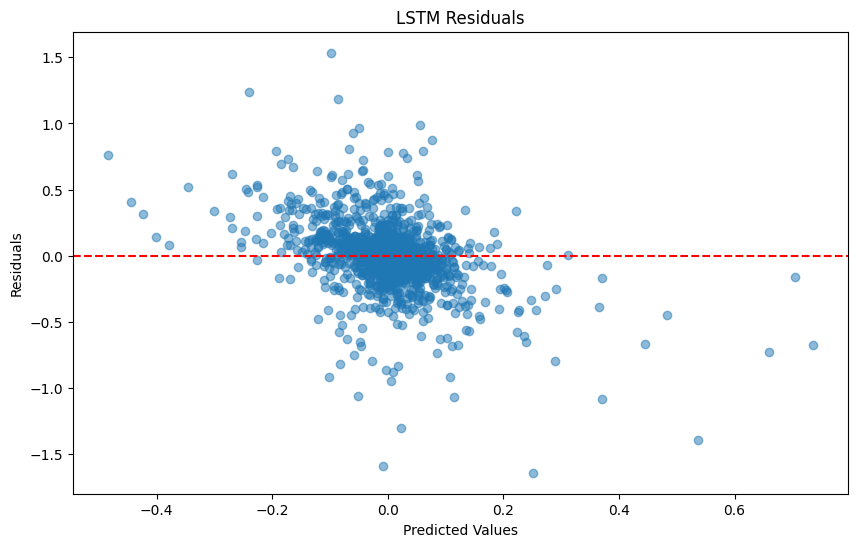

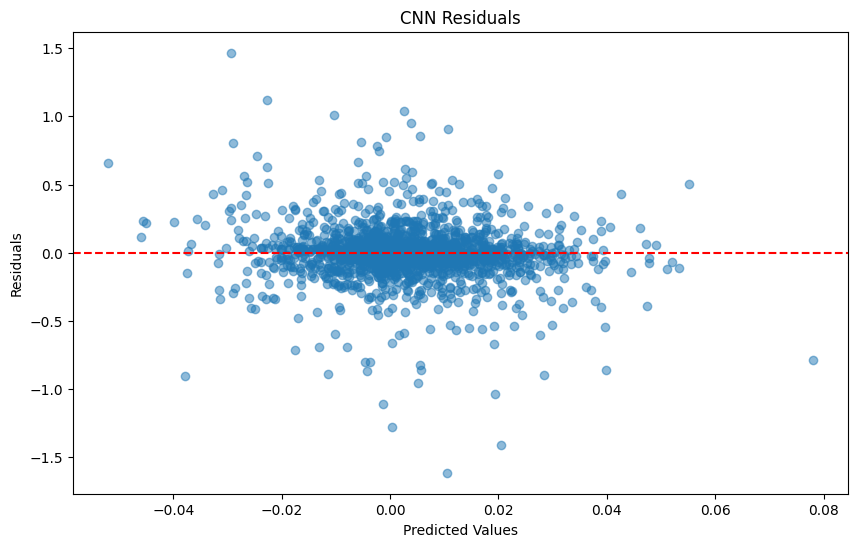

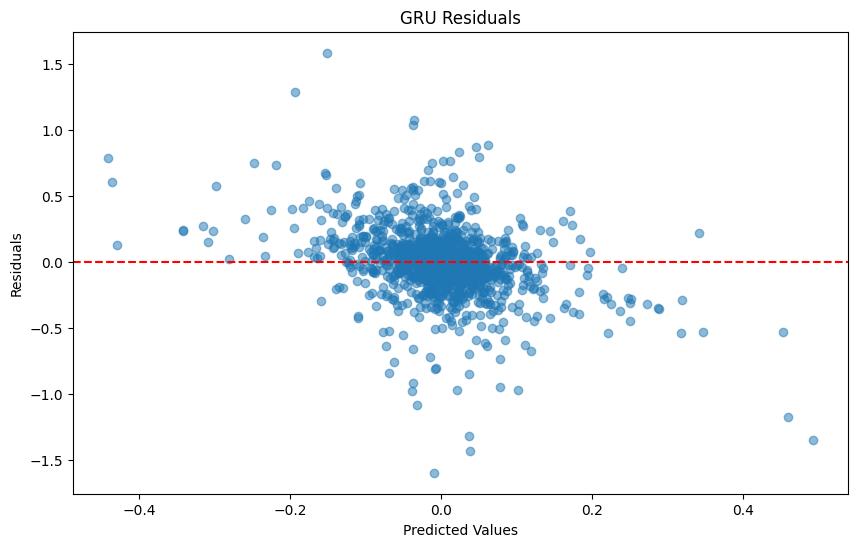

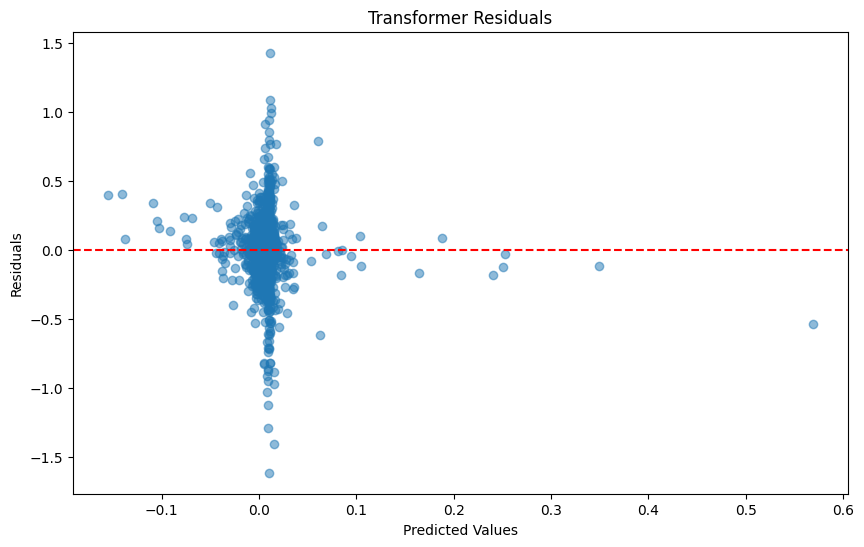

In [41]:
# Residual Plots to analyze the errors (residuals).

import matplotlib.pyplot as plt

# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} Residuals')
    plt.show()

# Plot residuals for each model
plot_residuals(y_test, lr_predictions, 'Linear Regression')
plot_residuals(y_test, rf_predictions, 'Random Forest')
plot_residuals(y_test, xgb_predictions, 'XGBoost')
plot_residuals(y_test, ffnn_predictions.flatten(), 'FFNN')
plot_residuals(y_test, lstm_predictions.flatten(), 'LSTM')
plot_residuals(y_test, cnn_predictions.flatten(), 'CNN')
plot_residuals(y_test, gru_predictions.flatten(), 'GRU')
plot_residuals(y_test, transformer_predictions.flatten(), 'Transformer')


<ipython-input-42-49c65453977d>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
<ipython-input-42-49c65453977d>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')
<ipython-input-42-49c65453977d>:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')


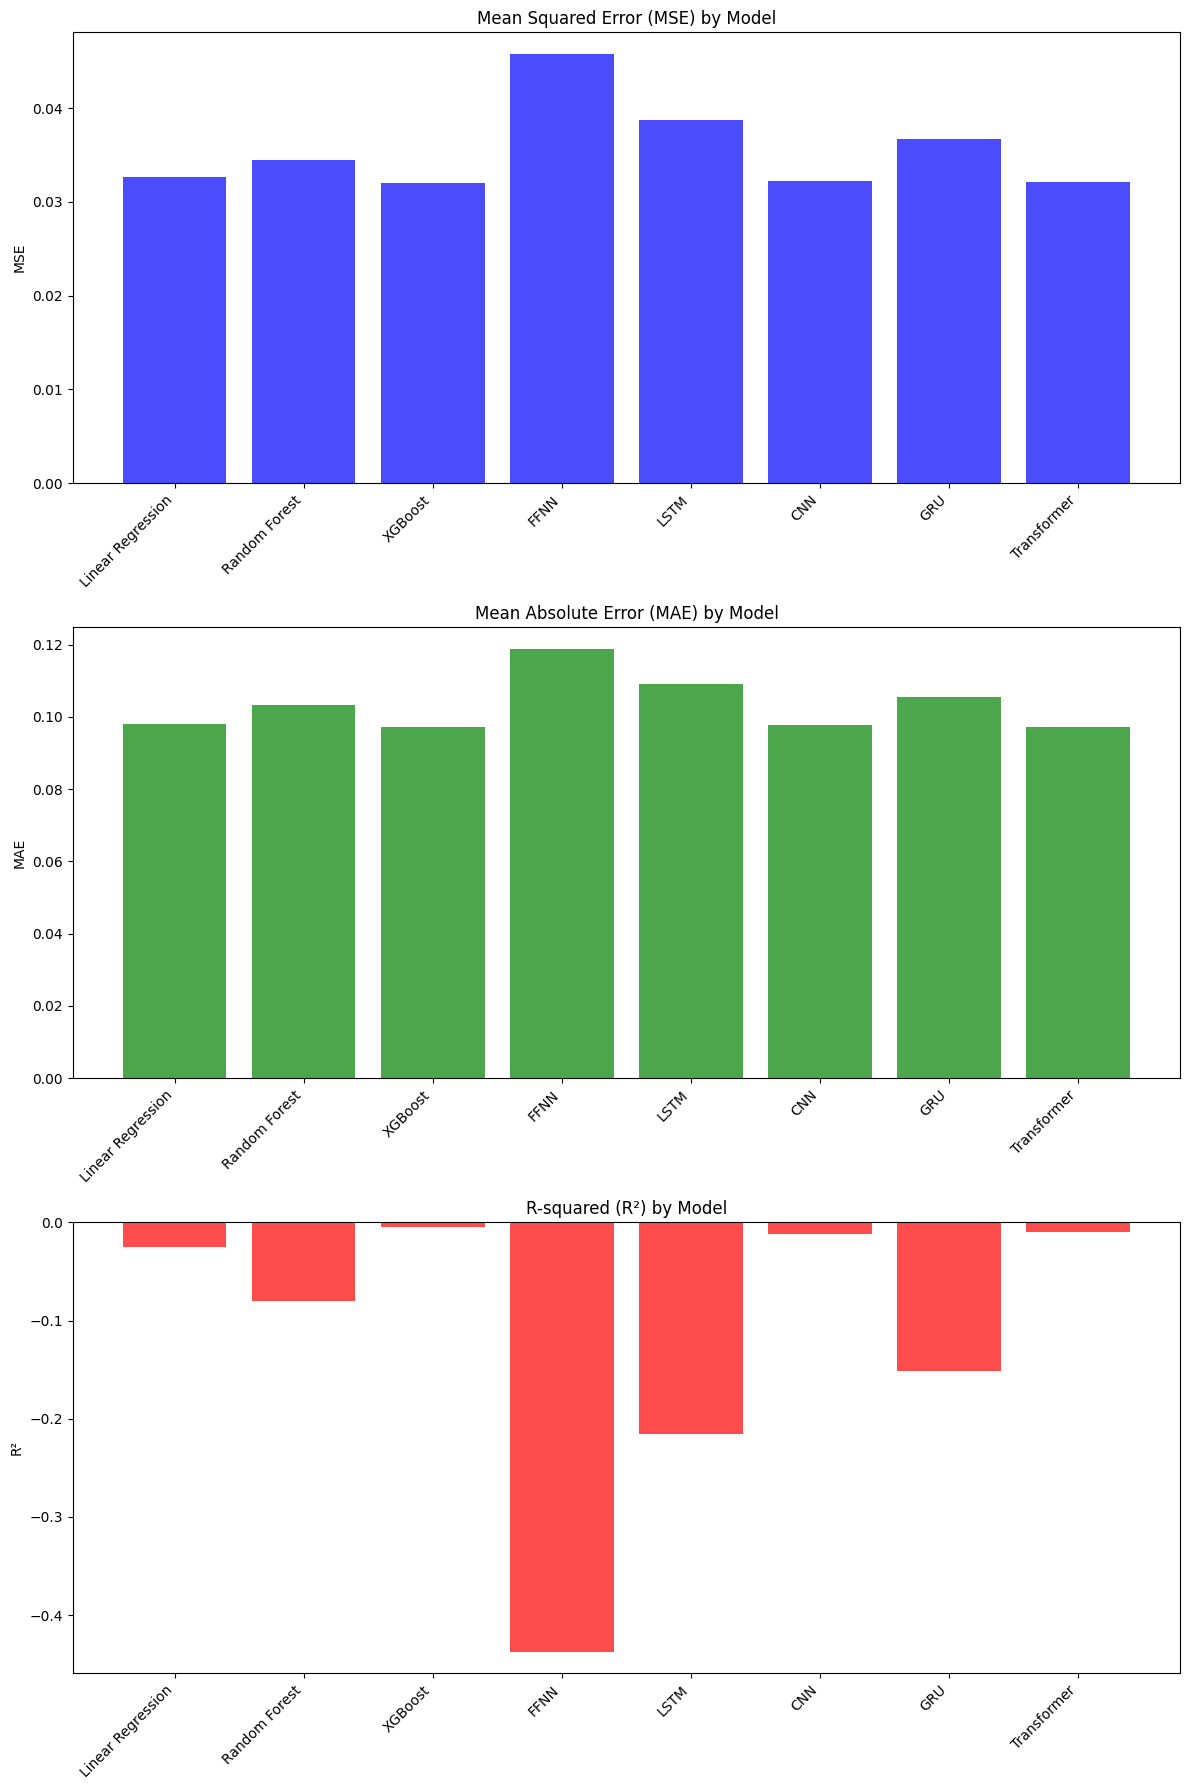

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate performance metrics
metrics = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'FFNN', 'LSTM', 'CNN', 'GRU', 'Transformer'],
    'MSE': [
        mean_squared_error(y_test, lr_predictions),
        mean_squared_error(y_test, rf_predictions),
        mean_squared_error(y_test, xgb_predictions),
        mean_squared_error(y_test, ffnn_predictions.flatten()),
        mean_squared_error(y_test, lstm_predictions.flatten()),
        mean_squared_error(y_test, cnn_predictions.flatten()),
        mean_squared_error(y_test, gru_predictions.flatten()),
        mean_squared_error(y_test, transformer_predictions.flatten())
    ],
    'MAE': [
        mean_absolute_error(y_test, lr_predictions),
        mean_absolute_error(y_test, rf_predictions),
        mean_absolute_error(y_test, xgb_predictions),
        mean_absolute_error(y_test, ffnn_predictions.flatten()),
        mean_absolute_error(y_test, lstm_predictions.flatten()),
        mean_absolute_error(y_test, cnn_predictions.flatten()),
        mean_absolute_error(y_test, gru_predictions.flatten()),
        mean_absolute_error(y_test, transformer_predictions.flatten())
    ],
    'R²': [
        r2_score(y_test, lr_predictions),
        r2_score(y_test, rf_predictions),
        r2_score(y_test, xgb_predictions),
        r2_score(y_test, ffnn_predictions.flatten()),
        r2_score(y_test, lstm_predictions.flatten()),
        r2_score(y_test, cnn_predictions.flatten()),
        r2_score(y_test, gru_predictions.flatten()),
        r2_score(y_test, transformer_predictions.flatten())
    ]
}

# Create a DataFrame
metrics_df = pd.DataFrame(metrics)

# Plot performance metrics
fig, ax = plt.subplots(3, 1, figsize=(12, 18))

# Plot MSE
ax[0].bar(metrics_df['Model'], metrics_df['MSE'], color='b', alpha=0.7)
ax[0].set_title('Mean Squared Error (MSE) by Model')
ax[0].set_ylabel('MSE')
ax[0].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')

# Plot MAE
ax[1].bar(metrics_df['Model'], metrics_df['MAE'], color='g', alpha=0.7)
ax[1].set_title('Mean Absolute Error (MAE) by Model')
ax[1].set_ylabel('MAE')
ax[1].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')

# Plot R²
ax[2].bar(metrics_df['Model'], metrics_df['R²'], color='r', alpha=0.7)
ax[2].set_title('R-squared (R²) by Model')
ax[2].set_ylabel('R²')
ax[2].set_xticklabels(metrics_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()
